## Goal - compare relus to smooth spline layer

- [issue link](https://i12g-gagneurweb.informatik.tu-muenchen.de/gitlab/avsec/deepcis/issues/51), see plot c)

## Claims

- GAM smooth layer helps with performance and can be used with any quantitative track
- GAMsmooth is more interpretable, easier to fit and leads to better performance

## Tasks

**Overall goal:** compare using relus to GAMSmooth layer for both tasks: concise deep and concise interpretable


- [x] modify the code in train, data and model
- [x] run the code for deep and shallow
- [x] plot ROC and PR curves for best 5 models of both classes and both use-cases (deep and shallow)
     - include the results to ROC and PR curves?
- [x] plot the positional dependence of features (partial-dependence plot)
- [x] write out the f1/accuracy loss curves for each of the models (gam vs relu)
- [ ] plot many of the loss curves


## TODO 

- add get_model(tid) method to CMongoTrials

---

In [112]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
from IPython.display import display # print like on return
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from concise.hyopt import CompileFN, CMongoTrials, test_fn
import numpy as np
import pandas as ps
from concise.utils.splines import BSpline
from concise.utils.model_data import split_train_test_idx, subset
from keras.models import load_model
import sklearn.metrics as skm
import concise.eval_metrics as cem
import keras.layers as kl
from keras.models import Model
import keras.callbacks as kc
import data
import model
from helper import *
import seaborn
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

DB_NAME = "Concise__Splice_branchpoints"
DATA_DIR = os.path.expanduser("~/projects-work/deepcis/data/")
EXP_DIR = DATA_DIR + "/Concise/Splice_branchpoints/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get each of the trials

- Name them as this: t_deep_gam, t_shallow_relu

In [113]:
#exp_name = "model_shallow"
#exp_name = "model_shallow2"
#exp_name = "model_shallow_multiply"

In [114]:
HOST = "ouga03"
t_deep_gam = CMongoTrials(DB_NAME, "model_deep", ip=HOST, kill_timeout=30 * 60)
t_deep_relu = CMongoTrials(DB_NAME, "model_deep_position=relu_scaled", ip=HOST, kill_timeout=30 * 60)
t_shallow_gam = CMongoTrials(DB_NAME, "model_shallow2", ip=HOST, kill_timeout=30 * 60)
t_shallow_gam_mul = CMongoTrials(DB_NAME, "model_shallow_multiply", ip=HOST, kill_timeout=30 * 60)
t_shallow_relu = CMongoTrials(DB_NAME, "model_shallow_position=relu_scaled", ip=HOST, kill_timeout=30 * 60)

In [115]:
all_trials = [["deep_gam", t_deep_gam], 
              ["deep_relu", t_deep_relu],
              ["shallow_gam", t_shallow_gam],
              ["shallow_gam_mul", t_shallow_gam_mul],
              ["shallow_relu", t_shallow_relu]]

In [116]:
## TODO - how to print nicely the table?
N_top_tids=100
for i, (name, t) in enumerate(all_trials):
    print("name: ", name)
    df = t.as_df().sort_values("eval.auprc", ascending=False)
    df.to_csv(EXP_DIR + "/trials/df/{0}.csv".format(name))
    all_trials[i].append({"top_tids": list(df.iloc[:N_top_tids]["tid"])})
    display(df.head(5))

name:  deep_gam


,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.n_bases,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs,param.model.lr,param.model.nonlinearity,param.model.pos_effect.l2,param.model.pos_effect.l2_smooth,param.model.pos_effect.merge.hidden_fc.activation,param.model.pos_effect.merge.hidden_fc.dropout_rate,param.model.pos_effect.merge.hidden_fc.n_hidden,param.model.pos_effect.merge.hidden_fc.n_layers,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
589,1704,-0.6795,ok,0.9617,0.9481,0.6795,0.5824,0.2187,0.1087,0.7813,0.4701,0.9919,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0018,relu,0,1.8044e-13,relu,0.2222,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,55.4963,285.6366,230.1403,2017-05-01 10:03:18.1...,2017-05-01 09:58:32.5...
939,2058,-0.6794,ok,0.9619,0.9472,0.6794,0.5873,0.2207,0.1098,0.7793,0.4768,0.9917,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0009,relu,0,6.5912e-16,relu,0.3178,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,55.8533,429.8302,373.9769,2017-05-01 15:47:45.9...,2017-05-01 15:40:36.1...
599,1718,-0.6792,ok,0.9616,0.9476,0.6792,0.5804,0.2171,0.1080,0.7829,0.4660,0.9920,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0026,relu,0,1.2122e-13,relu,0.2681,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.2211,307.0460,250.8249,2017-05-01 10:09:05.5...,2017-05-01 10:03:58.4...
443,1525,-0.6792,ok,0.9613,0.9486,0.6792,0.5546,0.1787,0.1094,0.8213,0.4238,0.9943,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0021,relu,0,8.7263e-18,relu,0.4771,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.4571,310.3179,253.8608,2017-05-01 00:17:33.0...,2017-05-01 00:12:22.7...
909,2028,-0.6792,ok,0.9619,0.9482,0.6792,0.5877,0.2187,0.1081,0.7813,0.4762,0.9918,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0006,relu,0,6.2145e-15,relu,0.3107,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.4162,407.3404,350.9241,2017-05-01 11:38:03.1...,2017-05-01 11:31:15.7...


name:  deep_relu


,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.encode_splines,param.data.minmax_scale,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs,param.model.lr,param.model.nonlinearity,param.model.pos_effect.activation,param.model.pos_effect.l2,param.model.pos_effect.merge.hidden_fc.activation,param.model.pos_effect.merge.hidden_fc.dropout_rate,param.model.pos_effect.merge.hidden_fc.n_hidden,param.model.pos_effect.merge.hidden_fc.n_layers,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.type,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
408,4751,-0.6760,ok,0.9615,0.9460,0.6760,0.5776,0.2174,0.1090,0.7826,0.4577,0.9922,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,4,60,None,0.0012,relu,None,8.1340e-13,relu,0.1769,70,2,concatenate,30,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,42.6692,736.8270,694.1578,2017-06-02 14:29:45.8...,2017-06-02 14:17:29.0...
770,5113,-0.6752,ok,0.9615,0.9462,0.6752,0.5796,0.2210,0.1097,0.7790,0.4615,0.9920,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,4,60,None,0.0008,relu,None,7.5447e-13,relu,0.1520,70,2,concatenate,20,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,32.7761,454.5946,421.8185,2017-06-02 16:02:54.1...,2017-06-02 15:55:19.5...
766,5109,-0.6746,ok,0.9613,0.9455,0.6746,0.6028,0.2641,0.1091,0.7359,0.5104,0.9888,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,4,60,None,0.0005,relu,None,2.3057e-12,relu,0.1664,70,2,concatenate,20,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,41.9587,688.3971,646.4385,2017-06-02 16:05:34.4...,2017-06-02 15:54:06.0...
989,5332,-0.6735,ok,0.9612,0.9454,0.6735,0.5961,0.2573,0.1092,0.7427,0.4979,0.9895,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,4,30,None,0.0005,relu,None,2.7360e-11,relu,0.0714,70,2,concatenate,30,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,35.2787,905.4907,870.2120,2017-06-02 17:26:17.1...,2017-06-02 17:11:11.7...
892,5235,-0.6733,ok,0.9612,0.9458,0.6733,0.5912,0.2503,0.1095,0.7497,0.4880,0.9901,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,4,60,None,0.0003,relu,None,2.1583e-16,relu,0.1860,70,2,concatenate,20,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,36.0311,1083.6195,1047.5885,2017-06-02 16:53:49.3...,2017-06-02 16:35:45.7...


name:  shallow_gam


,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.n_bases,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs.stddev,param.model.init_motifs.use_pssm,param.model.lr,param.model.nonlinearity,param.model.pos_effect.l2,param.model.pos_effect.l2_smooth,param.model.pos_effect.merge.hidden_fc,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
188,2663,-0.5955,ok,0.9571,0.9152,0.5955,0.5423,0.2957,0.1277,0.7043,0.4458,0.9885,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,2.5966e-04,True,0.0042,relu,1.8243e-05,4.8033e-05,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,103.8865,264.2417,160.3552,2017-05-02 00:36:40.0...,2017-05-02 00:32:15.7...
118,2593,-0.5954,ok,0.9574,0.9155,0.5954,0.5285,0.2701,0.1276,0.7299,0.4188,0.9905,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,3.0788e-03,True,0.0008,relu,8.0912e-06,8.8667e-10,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,138.3523,445.1432,306.7909,2017-05-02 00:25:55.9...,2017-05-02 00:18:30.7...
174,2649,-0.5952,ok,0.9573,0.9152,0.5952,0.5402,0.2878,0.1277,0.7122,0.4400,0.9891,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,2.6037e-04,True,0.0032,relu,1.4527e-05,2.3460e-10,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,55.4617,159.9615,104.4999,2017-05-02 00:31:43.5...,2017-05-02 00:29:03.5...
163,2638,-0.5952,ok,0.9575,0.9153,0.5952,0.5295,0.2689,0.1277,0.7311,0.4195,0.9905,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,3.4321e-05,True,0.0031,relu,9.4386e-06,1.0308e-10,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.1341,138.0939,81.9598,2017-05-02 00:28:52.2...,2017-05-02 00:26:34.1...
173,2648,-0.5952,ok,0.9574,0.9151,0.5952,0.5277,0.2670,0.1280,0.7330,0.4167,0.9906,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,2.0719e-05,True,0.0013,relu,1.1378e-04,1.6507e-07,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.8056,319.4521,262.6466,2017-05-02 00:34:17.4...,2017-05-02 00:28:57.9...


name:  shallow_gam_mul


,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.n_bases,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs.stddev,param.model.init_motifs.use_pssm,param.model.lr,param.model.nonlinearity,param.model.pos_effect.l2,param.model.pos_effect.l2_smooth,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
146,2857,-0.5864,ok,0.9563,0.9152,0.5864,0.4785,0.2333,0.1314,0.7667,0.3518,0.9934,data,auprc,auprc,model,20,2.0,True,128,val_loss,150,2,1,0.2753,False,0.0016,relu,3.4422e-17,0.0007,multiply,20,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,85.5796,219.3156,133.7360,2017-05-02 14:55:12.3...,2017-05-02 14:51:33.0...
31,2742,-0.5858,ok,0.9563,0.9158,0.5858,0.4799,0.2366,0.1313,0.7634,0.3536,0.9932,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.1368,True,0.0006,relu,9.7225e-15,0.0051,multiply,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,125.1102,573.8905,448.7802,2017-05-02 14:19:38.8...,2017-05-02 14:10:04.9...
169,2880,-0.5857,ok,0.9569,0.9150,0.5857,0.5045,0.2519,0.1315,0.7481,0.3846,0.9920,data,auprc,auprc,model,20,2.0,True,128,val_loss,150,2,1,0.2986,True,0.0011,relu,2.3416e-13,0.0065,multiply,20,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,107.5866,337.9986,230.4120,2017-05-02 15:02:43.7...,2017-05-02 14:57:05.7...
137,2848,-0.5854,ok,0.9561,0.9159,0.5854,0.4779,0.2417,0.1313,0.7583,0.3529,0.9931,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.1236,True,0.0010,relu,2.4561e-10,0.0001,multiply,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,72.5699,362.2746,289.7047,2017-05-02 14:55:39.6...,2017-05-02 14:49:37.3...
120,2831,-0.5854,ok,0.9563,0.9159,0.5854,0.4798,0.2368,0.1315,0.7632,0.3535,0.9932,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.0636,True,0.0005,relu,6.0114e-12,0.0030,multiply,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,120.3567,560.7660,440.4093,2017-05-02 14:54:11.1...,2017-05-02 14:44:50.3...


name:  shallow_relu


,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.encode_splines,param.data.minmax_scale,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs.stddev,param.model.init_motifs.use_pssm,param.model.lr,param.model.nonlinearity,param.model.pos_effect.activation,param.model.pos_effect.l2,param.model.pos_effect.merge.hidden_fc,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.type,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
107,4250,-0.5893,ok,0.9570,0.9119,0.5893,0.5307,0.2873,0.1283,0.7127,0.4227,0.9896,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,2,1,0.0049,True,0.0038,relu,None,1.6448e-13,NaN,concatenate,20,relu,True,/s/project/deepcis/hy...,/s/project/deepcis/hy...,42.7096,269.4945,226.7849,2017-06-02 11:48:25.7...,2017-06-02 11:43:56.2...
74,4217,-0.5883,ok,0.9568,0.9117,0.5883,0.5339,0.2959,0.1285,0.7041,0.4299,0.9890,data,auprc,auprc,model,False,True,2.0,True,128,val_loss,150,2,1,0.0051,True,0.0011,relu,None,7.8877e-12,NaN,concatenate,10,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,42.7492,669.0374,626.2882,2017-06-02 11:47:20.4...,2017-06-02 11:36:11.4...
129,4272,-0.5879,ok,0.9569,0.9114,0.5879,0.5116,0.2670,0.1287,0.7330,0.3930,0.9913,data,auprc,auprc,model,False,True,2.0,True,128,val_loss,150,2,1,0.0004,True,0.0009,relu,None,1.1146e-18,NaN,concatenate,20,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,39.5839,509.1561,469.5722,2017-06-02 11:54:57.7...,2017-06-02 11:46:28.5...
50,4193,-0.5874,ok,0.9568,0.9118,0.5874,0.5055,0.2607,0.1288,0.7393,0.3841,0.9917,data,auprc,auprc,model,False,True,2.0,False,128,val_loss,150,2,1,0.0081,True,0.0017,relu,None,6.3397e-14,NaN,concatenate,20,relu,True,/s/project/deepcis/hy...,/s/project/deepcis/hy...,40.3799,370.6322,330.2523,2017-06-02 11:37:29.7...,2017-06-02 11:31:19.1...
171,4314,-0.5870,ok,0.9568,0.9114,0.5870,0.5378,0.3020,0.1289,0.6980,0.4374,0.9885,data,auprc,auprc,model,False,True,2.0,True,128,val_loss,150,2,1,0.0066,True,0.0023,relu,None,1.8276e-15,NaN,concatenate,20,relu,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,32.5705,154.2339,121.6633,2017-06-02 11:57:25.2...,2017-06-02 11:54:51.0...


In [79]:
all_trials

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


[['deep_gam',
  {'tid_info': {1704: {'data': {'test': ({'canon_hit1': array([[[ 0.    ,  0.0672,  0.6074, ...,  0.    ,  0.    ,  0.    ],
                [ 0.    ,  0.1405,  0.6637, ...,  0.    ,  0.    ,  0.    ],
                [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
                ..., 
                [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
                [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
                [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
        
               [[ 0.1536,  0.666 ,  0.1805, ...,  0.    ,  0.    ,  0.    ],
                [ 0.0295,  0.5166,  0.4398, ...,  0.    ,  0.    ,  0.    ],
                [ 0.0753,  0.6188,  0.3038, ...,  0.    ,  0.    ,  0.    ],
                ..., 
                [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
                [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
                [ 0.    ,  0.    ,  0

## Load the data

In [117]:
N_tids = 1

In [118]:
def remove_background_probs(h5_file_path):
    """backcompatibility: Remove background_probs from the convDNA layer"""
    import h5py
    import json
    f5 = h5py.File(h5_file_path, "r+")
    conf = json.loads(f5.attrs["model_config"].decode('utf8'))
    conf

    for x in conf["config"]["layers"]:
        if x["class_name"] == "ConvDNA":
            print("remove")
            x["config"].pop("background_probs", None)

    f5.attrs["model_config"] = json.dumps(conf).encode("utf8")
    f5.close()   
    print("Done!")

In [119]:
h5_file_path = '/s/project/deepcis/hyperopt//Concise__Splice_branchpoints/model_deep//train_models/5b1dbbe4-6d1a-49b6-b819-868aa8c181b5.h5'

In [121]:
for i, (name, t, attr) in enumerate(all_trials):
    attr["tid_info"] = {}
    print("name: ", name)
    for tid in attr["top_tids"][:N_tids]:
        print("tid: ", tid)
        param = t.get_param(tid).to_dict()
        if name not in ["shallow_gam_mul", "shallow_gam", "shallow_relu"]:
            ## Fix the broken trial names
            param["data"]["truncate"] = False
        train, test = data.data(**param["data"])
        train_idx, valid_idx = split_train_test_idx(train, 
                                                    valid_split=.2, 
                                                    stratified=False, random_state=100)
        valid = subset(train, valid_idx, keep_other=False)
        train_train = subset(train, train_idx)
        mpath = t.get_trial(tid).to_dict()["result"]["path"]["model"]
        #remove_background_probs(mpath)
        attr["tid_info"][tid] = {"param": param,
                                 "train_all": train, 
                                  "data": {"train": train_train, 
                                           "valid": valid, 
                                           "test": test},
                                  "model": load_model(mpath)
                                  }

name:  deep_gam
tid:  1704
loading cached array
loading cached array
name:  deep_relu
tid:  4751
loading cached array
loading cached array
name:  shallow_gam
tid:  2663
loading cached array
loading cached array
Removing 1 pwm's from pwm_list
Removing 1 pwm's from pwm_list
name:  shallow_gam_mul
tid:  2857
loading cached array
loading cached array
Removing 1 pwm's from pwm_list
Removing 1 pwm's from pwm_list
name:  shallow_relu
tid:  4250
loading cached array
loading cached array
Removing 1 pwm's from pwm_list
Removing 1 pwm's from pwm_list


## Save predictions to csv

In [ ]:
for name, trials, attr in all_trials:
    print("name: ", name)
    for i, tid in enumerate(attr["top_tids"][:N_tids]):
        print("tid: ", tid)
        m = attr["tid_info"][tid]["model"]
        d = attr["tid_info"][tid]["data"]
        
        y_pred = m.predict(d["test"][0])
        y_true = d["test"][1]
        dt_pred = pd.DataFrame({"y_true": y_true.reshape((-1,)), "y_pred": y_pred.reshape((-1,))})
        dt_pred = dt_pred[dt_pred["y_true"] != -1]
        dt_pred["y_true"] = np.where(dt_pred["y_true"]== 1, "HC", "NEG")
        dt_pred.sort_values("y_pred")
        dt_pred.to_csv("/s/project/deepcis/Concise/Splice_branchpoints/test_predictions/{0}_{1}.csv".format(name,i),
                      index=False)

name:  deep_gam
tid:  1704
name:  deep_relu
tid:  4751
name:  shallow_gam
tid:  2663
name:  shallow_gam_mul
tid:  2857


## Plot best roc and pr for each of the 4 tasks

- use top 5 models


name:  deep_gam
tid:  1704


,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auc,auprc
0,train,0.0977,0.9355,0.6215,0.8137,0.5027,0.5027,0.9930,0.1863,0.9592,0.7274
1,test,0.1065,0.9327,0.5621,0.7357,0.4548,0.4548,0.9906,0.2643,0.9477,0.6508
2,valid,0.1087,0.9332,0.5834,0.7780,0.4667,0.4667,0.9919,0.2220,0.9481,0.6795


name:  deep_relu
tid:  4751


,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auc,auprc
0,train,0.1012,0.9344,0.6203,0.7747,0.5173,0.5173,0.9909,0.2253,0.9552,0.7082
1,test,0.1072,0.9323,0.5719,0.7107,0.4784,0.4784,0.9888,0.2893,0.9465,0.6451
2,valid,0.1090,0.9328,0.5944,0.7491,0.4927,0.4927,0.9899,0.2509,0.9460,0.6742


name:  shallow_gam
tid:  2663


,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auc,auprc
0,train,0.1259,0.9280,0.5425,0.6973,0.4440,0.4440,0.9883,0.3027,0.9194,0.5982
1,test,0.1218,0.9293,0.5332,0.6722,0.4418,0.4418,0.9876,0.3278,0.9222,0.5838
2,valid,0.1276,0.9287,0.5422,0.7008,0.4421,0.4421,0.9885,0.2992,0.9152,0.5955


name:  shallow_gam_mul
tid:  2857


,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auc,auprc
0,train,0.1294,0.9272,0.4800,0.7559,0.3516,0.3516,0.9931,0.2441,0.9184,0.5892
1,test,0.1245,0.9288,0.4637,0.7361,0.3385,0.3385,0.9930,0.2639,0.9219,0.5756
2,valid,0.1314,0.9279,0.4786,0.7622,0.3488,0.3488,0.9934,0.2378,0.9152,0.5864


name:  shallow_relu
tid:  4250


,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auc,auprc
0,train,0.1272,0.9278,0.5226,0.7173,0.4110,0.4110,0.9902,0.2827,0.9151,0.5888
1,test,0.1221,0.9295,0.5169,0.6944,0.4116,0.4116,0.9896,0.3056,0.9190,0.5774
2,valid,0.1283,0.9286,0.5215,0.7231,0.4078,0.4078,0.9905,0.2769,0.9122,0.5887


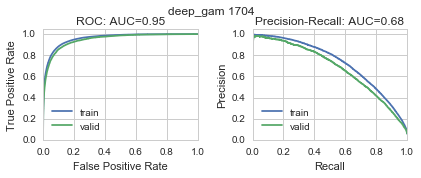

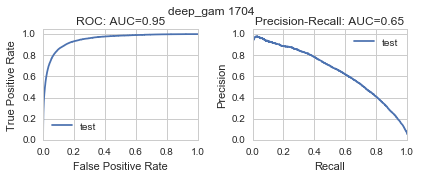

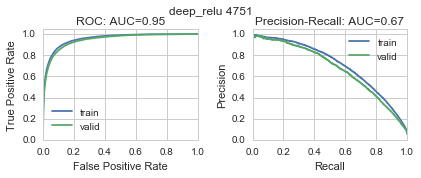

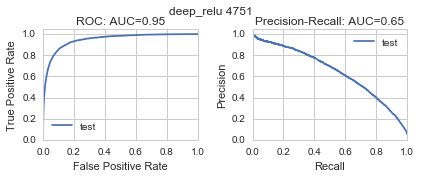

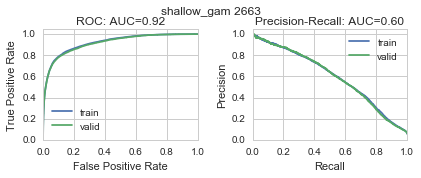

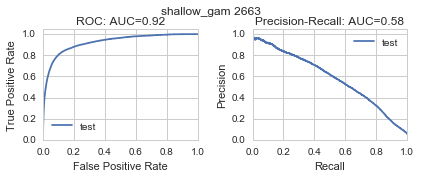

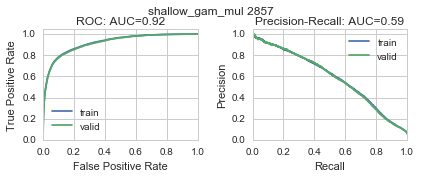

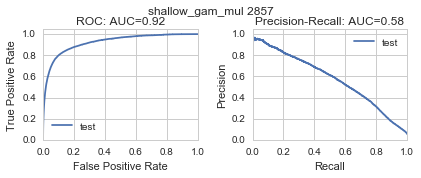

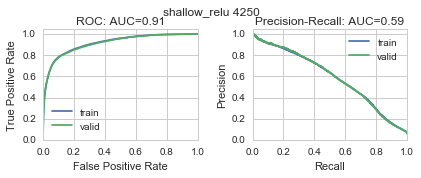

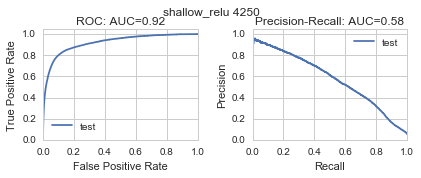

In [13]:
for name, trials, attr in all_trials:
    print("name: ", name)
    for tid in attr["top_tids"][:N_tids]:
        print("tid: ", tid)
        m = attr["tid_info"][tid]["model"]
        d = attr["tid_info"][tid]["data"]
        display(metrics_dt(m, d))
        plot_roc_pr(m, [d["train"], d["valid"]], ["train", "valid"])
        plt.suptitle(name + " " + str(tid), fontsize=12)
        plot_roc_pr(m, [d["test"]], ["test"])
        plt.suptitle(name + " " + str(tid), fontsize=12)

## Plot model architecture

In [14]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [15]:
for name, trials, attr in all_trials:
    print("name: ", name)
    for tid in attr["top_tids"][:N_tids]:
        print("tid: ", tid)
        m = attr["tid_info"][tid]["model"]
        d = attr["tid_info"][tid]["data"]
        SVG(model_to_dot(m).create(prog='dot', format='svg'))

name:  deep_gam
tid:  1704
name:  deep_relu
tid:  4751
name:  shallow_gam
tid:  2663
name:  shallow_gam_mul
tid:  2857
name:  shallow_relu
tid:  4250


## Plot loss curves for each of the 4 tasks

- use top 5 models

In [16]:
df_hist = pd.concat([trials.train_history(tid).assign(trial=name) 
                     for name, trials, attr in all_trials for tid in attr["top_tids"] ])
df_hist.to_csv(EXP_DIR + "/trials/train_history/gam_vs_relu.csv")

In [17]:
t_deep_gam.train_history(1704)

,tid,epoch,accuracy,f1,fdr,loss,precision,sensitivity_1,sensitivity_2,specificity,val_accuracy,val_f1,val_fdr,val_loss,val_precision,val_sensitivity_1,val_sensitivity_2,val_specificity
0,1704,0,0.9408,NaN,NaN,0.2110,NaN,0.0026,0.0026,0.9978,0.9425,NaN,NaN,0.1393,NaN,0.0000,0.0000,1.0000
1,1704,1,0.9427,NaN,NaN,0.1349,NaN,0.0000,0.0000,1.0000,0.9425,NaN,NaN,0.1303,NaN,0.0000,0.0000,1.0000
2,1704,2,0.9466,NaN,NaN,0.1277,NaN,0.0972,0.0972,0.9982,0.9569,0.4751,0.2104,0.1251,0.7896,0.3408,0.3408,0.9945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,1704,24,0.9638,0.6184,0.2194,0.1015,0.7806,0.5135,0.5135,0.9912,0.9618,0.5741,0.1997,0.1084,0.8003,0.4489,0.4489,0.9932
25,1704,25,0.9639,0.6194,0.2159,0.1012,0.7841,0.5137,0.5137,0.9913,0.9616,0.5907,0.2392,0.1080,0.7608,0.4838,0.4838,0.9907
26,1704,26,0.9641,0.6234,0.2182,0.1008,0.7818,0.5199,0.5199,0.9912,0.9617,0.5830,0.2214,0.1087,0.7786,0.4671,0.4671,0.9919


name:  deep_gam
tid:  1704
name:  deep_relu
tid:  4751
name:  shallow_gam
tid:  2663
name:  shallow_gam_mul
tid:  2857
name:  shallow_relu
tid:  4250


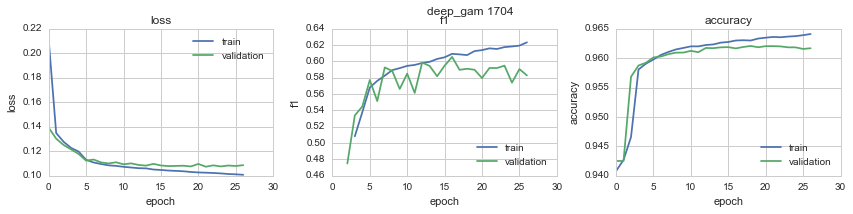

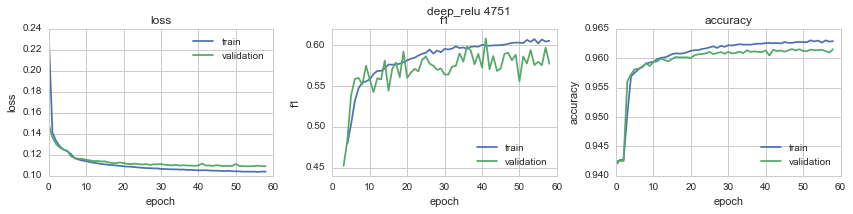

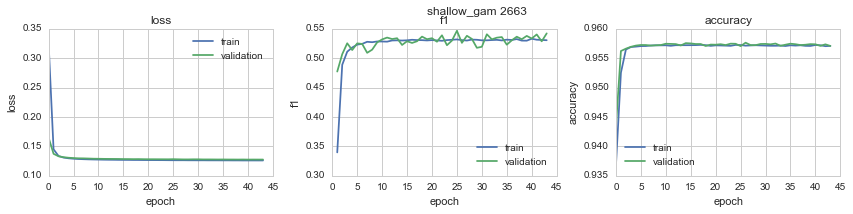

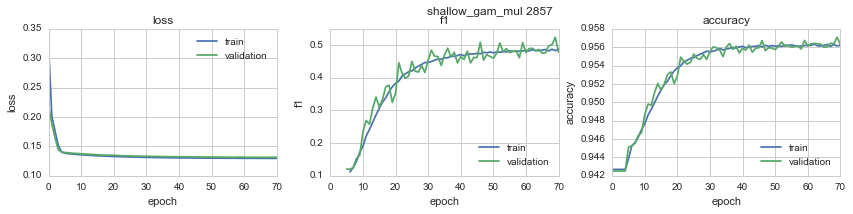

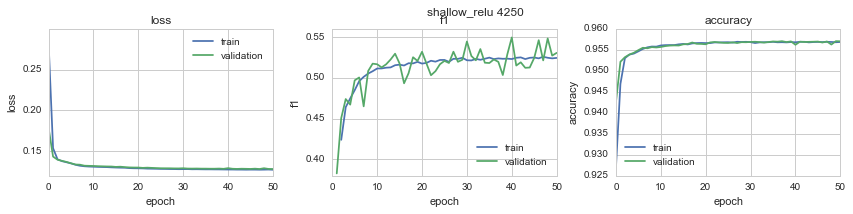

In [18]:
DIR = "/s/project/deepcis/plots/Concise/Splice_branchpoints/loss_curves/"
for i, (name, trials, attr) in enumerate(all_trials):
    print("name: ", name)
    for tid in attr["top_tids"][:N_tids]:
        print("tid: ", tid)
        fig = plot_history(trials, tid, figsize=(12,3))
        fig.savefig(DIR + name + "_" + "tid=" + str(tid) + ".jpg", dpi=600)
        fig.savefig(DIR + name + "_" + "tid=" + str(tid) + ".pdf")
        plt.suptitle(name + " " + str(tid), fontsize=12, ha="left")

## Inspect the fitting results

- faster convergence? (see train loss metric)
   - yes regarding the overall fitting precision
- better overall performance?

### Make the performance boxplots

In [19]:
dtp = pd.concat([pd.DataFrame({"auprc": t.as_df()["eval.auprc"], 
                               "method": name.split("_")[1], 
                               "type": name.split("_")[0]}) 
                 for name, t, attr in all_trials if name is not "shallow_gam_mul"])

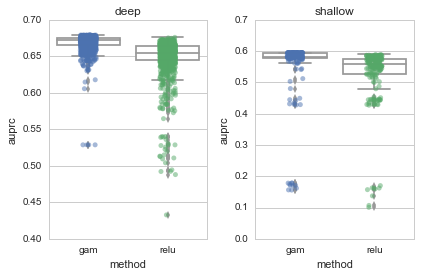

In [20]:
fig = plt.figure(figsize=(6, 4))
for i, t in enumerate(["deep", "shallow"]):
    plt.subplot(1,2,i+1)
    sns.boxplot(x="method", y="auprc", color="white", data=dtp[dtp.type == t])
    sns.stripplot(x="method", y = "auprc", data = dtp[dtp.type == t], 
                  jitter=True, alpha=0.5)
    plt.tight_layout()
    plt.title(t)

In [21]:
fig.savefig("/s/project/deepcis/plots/Concise/Splice_branchpoints/gam_vs_relu_boxplot.png", dpi=600)
fig.savefig("/s/project/deepcis/plots/Concise/Splice_branchpoints/gam_vs_relu_boxplot.pdf", )

## Plot the positional effects

- choose the top model from each category
- plot its positional effect
   - with relu's, use partial dependance plots

In [12]:
[x[0] for x in all_trials]

['deep_gam', 'deep_relu', 'shallow_gam', 'shallow_gam_mul', 'shallow_relu']

In [110]:
def partial_dependence(model, data, key, values):
    def get_new_data(train, xr, which):
        from copy import deepcopy

        def get_new_train_one(i, train, xr, which):
            xtrain = deepcopy(train)
            xrval = xr[i][np.newaxis]
            xrval = np.repeat(xrval, train[1].shape[0], axis=0)
            xtrain[0][which] = xrval
            return xtrain
        return [get_new_train_one(i, train, xr, which) for i in tqdm_notebook(range(xr.shape[0]))]

    new_data_list = get_new_data(data, values, key)
    y = np.stack([model.predict(d[0]) for d in tqdm_notebook(new_data_list)])

    return values, y

In [111]:
name, trials, attr = all_trials[2]
tid = attr["top_tids"][0]
m = attr["tid_info"][tid]["model"]
param = attr["tid_info"][tid]["param"]
train = attr["tid_info"][tid]["train_all"]

ValueError: not enough values to unpack (expected 3, got 2)

In [83]:
xr = np.repeat(np.linspace(0, 1, 50).reshape((-1,1)), 27, axis=1)

In [94]:
feat = "ppt_start"
n_bases = train[0][feat].shape[2]

In [95]:
from concise.preprocessing import encodeSplines

In [96]:
xr_s = encodeSplines(xr, n_bases=n_bases, start=0, end = 1)

In [97]:
x, y = partial_dependence(m, train, feat, xr_s.reshape((-1,27,n_bases))) 




  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:00<00:20,  2.45it/s]


  4%|▍         | 2/50 [00:00<00:19,  2.42it/s]


  6%|▌         | 3/50 [00:01<00:19,  2.45it/s]


  8%|▊         | 4/50 [00:01<00:19,  2.32it/s]


 10%|█         | 5/50 [00:02<00:20,  2.19it/s]


 12%|█▏        | 6/50 [00:02<00:21,  2.09it/s]


 14%|█▍        | 7/50 [00:03<00:21,  2.03it/s]


 16%|█▌        | 8/50 [00:03<00:20,  2.00it/s]


 18%|█▊        | 9/50 [00:04<00:20,  1.97it/s]


 20%|██        | 10/50 [00:04<00:20,  1.95it/s]


 22%|██▏       | 11/50 [00:05<00:20,  1.93it/s]


 24%|██▍       | 12/50 [00:05<00:19,  1.92it/s]


 26%|██▌       | 13/50 [00:06<00:19,  1.91it/s]


 28%|██▊       | 14/50 [00:06<00:18,  1.90it/s]


 30%|███       | 15/50 [00:07<00:18,  1.90it/s]


 32%|███▏      | 16/50 [00:08<00:17,  1.90it/s]


 34%|███▍      | 17/50 [00:08<00:17,  1.89it/s]


 36%|███▌      | 18/50 [00:09<00:16,  1.89it/s]


 38%|███▊      | 19/50 [00:09<00:16,  1.89it/s]


 40%|████      

In [100]:
x2, y2 = xr.mean(1).reshape((-1)), y.mean(1).mean(1).reshape((-1))

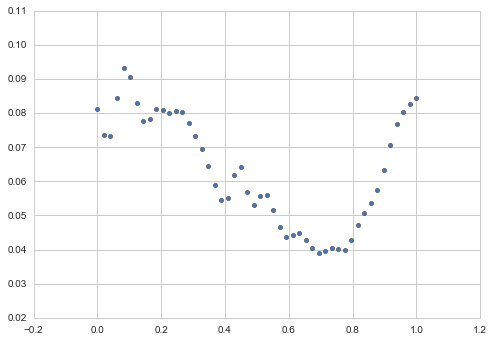

In [101]:
plt.scatter(x2,y2)

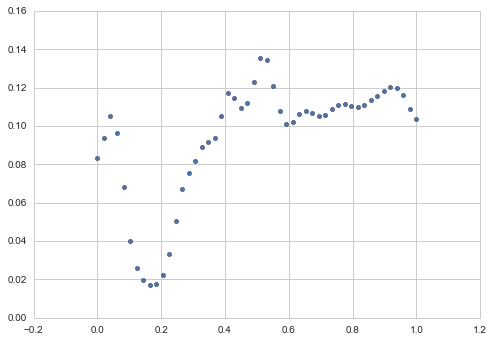

In [53]:
plt.scatter(x2,y2)

array([[[ 0.    ],
        [ 0.0075],
        [ 0.0149],
        [ 0.0224],
        [ 0.0299],
        [ 0.0373],
        [ 0.0448],
        [ 0.0522],
        [ 0.0597],
        [ 0.0672],
        [ 0.0746],
        [ 0.0821],
        [ 0.0896],
        [ 0.097 ],
        [ 0.1045],
        [ 0.1119],
        [ 0.1194],
        [ 0.1269],
        [ 0.1343],
        [ 0.1418],
        [ 0.1493],
        [ 0.1567],
        [ 0.1642],
        [ 0.1716],
        [ 0.1791],
        [ 0.1866],
        [ 0.194 ]],

       [[ 0.2015],
        [ 0.209 ],
        [ 0.2164],
        [ 0.2239],
        [ 0.2313],
        [ 0.2388],
        [ 0.2463],
        [ 0.2537],
        [ 0.2612],
        [ 0.2687],
        [ 0.2761],
        [ 0.2836],
        [ 0.291 ],
        [ 0.2985],
        [ 0.306 ],
        [ 0.3134],
        [ 0.3209],
        [ 0.3284],
        [ 0.3358],
        [ 0.3433],
        [ 0.3507],
        [ 0.3582],
        [ 0.3657],
        [ 0.3731],
        [ 0.3806],
        [ 

In [50]:
train[0]["dist2"].shape

(28042, 27, 1)

In [37]:
if "relu" in name:
    dfpos = plot_pos_dep_relu(m, param, train, scaled=True)
else:
    dfpos = plot_pos_dep(m, param, train)
plt.suptitle(name + " " + str(tid), fontsize=20)
attr["tid_info"][tid]["dfpos"] = dfpos

name:  deep_gam
tid:  1704
name:  deep_relu
tid:  4751
name:  shallow_gam
tid:  2663
name:  shallow_gam_mul
tid:  2857
name:  shallow_relu
tid:  4250


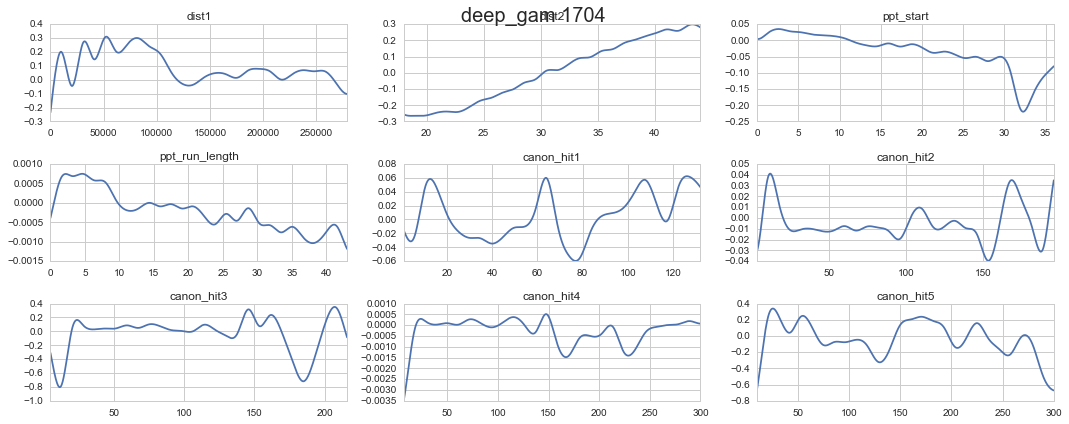

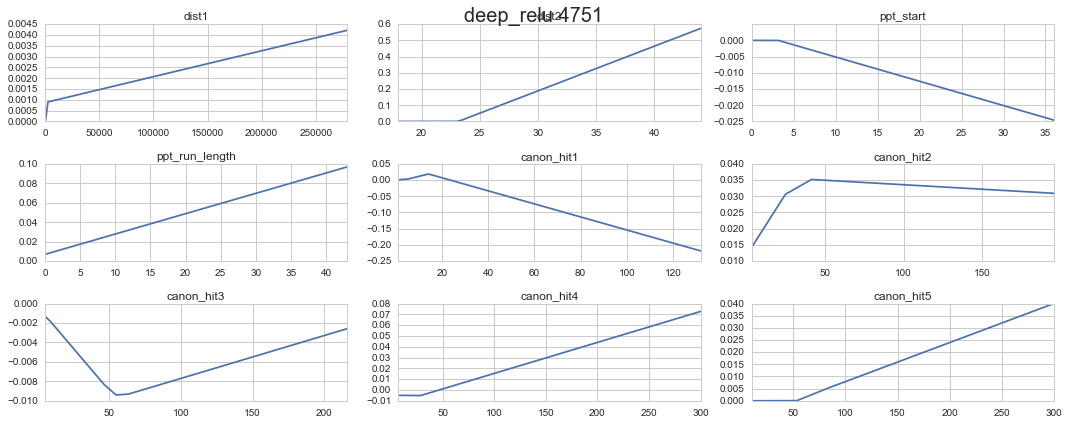

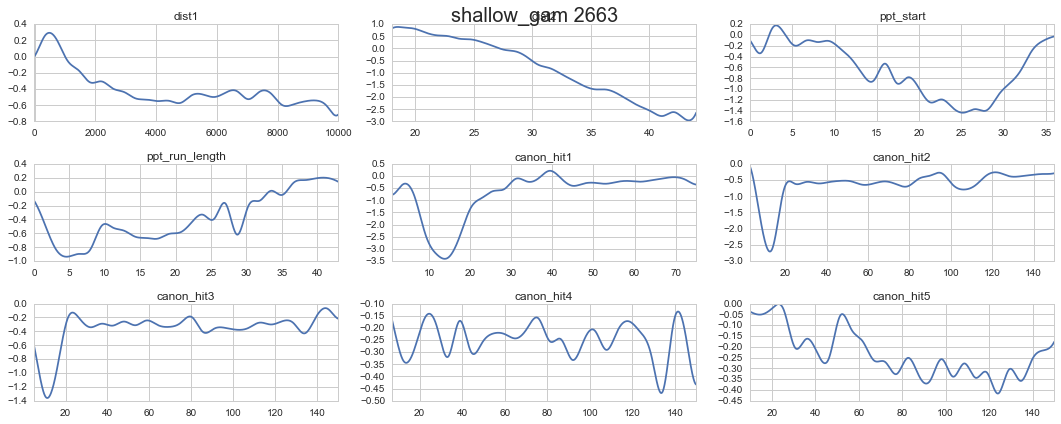

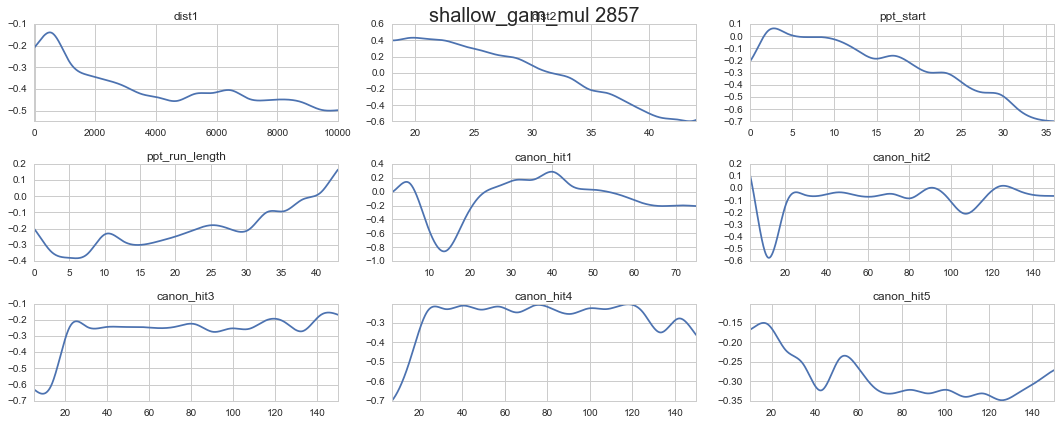

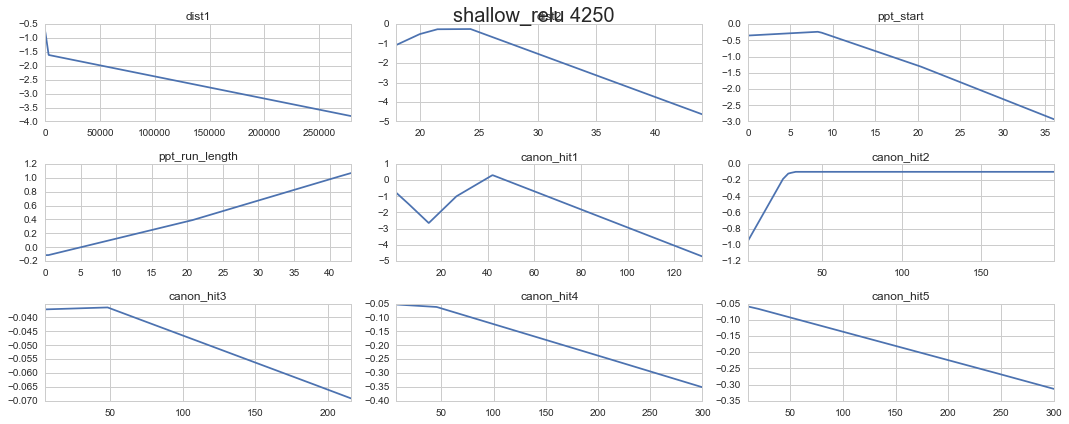

In [31]:
for name, trials, attr in all_trials:
    print("name: ", name)
    for tid in attr["top_tids"][:N_tids]:
        print("tid: ", tid)
        m = attr["tid_info"][tid]["model"]
        param = attr["tid_info"][tid]["param"]
        train = attr["tid_info"][tid]["train_all"]
        if "relu" in name:
            dfpos = plot_pos_dep_relu(m, param, train, scaled=True)
        else:
            dfpos = plot_pos_dep(m, param, train)
        plt.suptitle(name + " " + str(tid), fontsize=20)
        attr["tid_info"][tid]["dfpos"] = dfpos

### Save the resulting features

In [34]:
for name, trials, attr in all_trials:
    for tid in attr["top_tids"][:N_tids]:
        dfpos = attr["tid_info"][tid]["dfpos"]
        print("name: {name}, tid: {tid}".format(name=name, tid=tid))
        dfpos.to_csv("/s/project/deepcis/Concise/Splice_branchpoints/interpret/position/{0}_tid={1}.csv".
                    format(name, tid))

name: deep_gam, tid: 1704
name: deep_relu, tid: 4751
name: shallow_gam, tid: 2663
name: shallow_gam_mul, tid: 2857
name: shallow_relu, tid: 4250


In [35]:
ls /s/project/deepcis/Concise/Splice_branchpoints/interpret/position/

concise_shallow.csv             shallow_gam_mul_tid=2857.csv
deep_gam_tid=1704_2.csv         shallow_gam_tid=2663_2.csv
deep_gam_tid=1704.csv           shallow_gam_tid=2663.csv
deep_relu_tid=3753.csv          shallow_relu_tid=2977.csv
deep_relu_tid=4751_2.csv        shallow_relu_tid=4250_2.csv
deep_relu_tid=4751.csv          shallow_relu_tid=4250.csv
shallow_gam_mul_tid=2857_2.csv
